In [1]:
import ntpath
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
import cv2

2023-06-12 14:58:59.933282: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
input_shape = (224, 224)
number_of_epochs = 1
'''
train_percentage = 0.7
validation_percentage = 0.2
test_percentage = 0.1
'''
weights_directory = "/Users/andreacivitarese/PycharmProjects/CVandDL/classification/weights"
results_directory = "/Users/andreacivitarese/PycharmProjects/CVandDL/classification/results"
path_dataset_men = "/Users/andreacivitarese/PycharmProjects/CVandDL/dataset_classificazione/men/"
path_dataset_women = "/Users/andreacivitarese/PycharmProjects/CVandDL/dataset_classificazione/women/"


In [4]:
# Codice per ottenere il path delle immagini da classificare
imgs_list_men = [os.path.join(path_dataset_men, img_name) for img_name in sorted(os.listdir(path_dataset_men))]
imgs_list_women = [os.path.join(path_dataset_women, img_name) for img_name in sorted(os.listdir(path_dataset_women))]
imgs_list = imgs_list_men + imgs_list_women

print("Numero totale immagini: " + str(len(imgs_list)))

imgs_array = []
for file_path in imgs_list:
    img = cv2.imread(file_path)
    img = cv2.resize(img, input_shape)
    #RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgs_array.append(img)

Numero totale immagini: 1402


/Users/andreacivitarese/PycharmProjects/CVandDL/dataset_classificazione/men/100_BALENCIAGA_leather.jpg


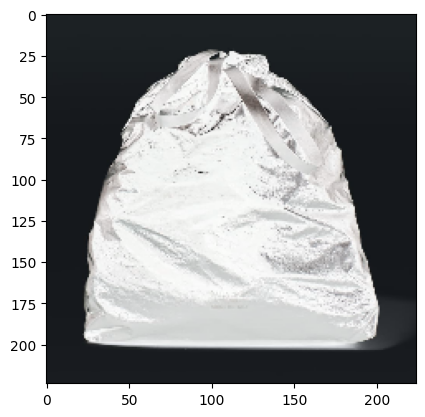

In [5]:
print(imgs_list[1])
imgplot = plt.imshow(255-imgs_array[1], vmin=0, vmax=255)

In [8]:
# creazione delle etichette delle immagini
possible_materials = set()
for image_path in imgs_list:
    head, image_name = ntpath.split(image_path)
    index, brand, material = image_name.split('_')
    possible_materials.add(material.split('.')[0])
list_possible_materials = list(possible_materials)

print("Numero possibili materiali: " + str(len(possible_materials)))
print(list_possible_materials)

labels = []

for image_path in imgs_list:
    head, image_name = ntpath.split(image_path)
    index, brand, material = image_name.split('_')
    label = np.zeros(shape=len(possible_materials), dtype=float)
    materiale = material.split('.')[0]
    indice = list_possible_materials.index(materiale)
    label[indice] = 1
    labels.append(label)

print(str(len(labels)))
print(labels[0])

Numero possibili materiali: 10
['polyester', 'polyurethane', 'raffia', 'leather', 'lamb-leather', 'goat-leather', 'cow-leather', 'fabric', 'canvas', 'calf-leather']
1402
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [9]:
from sklearn.model_selection import train_test_split

images_array, labels_array = sklearn.utils.shuffle(imgs_array, labels, random_state=15)
Xtrain, X_test, Ytrain, Y_test = train_test_split(images_array,labels_array, test_size=0.10,  random_state=15, stratify=labels_array)
X_train, X_valid, Y_train, Y_valid = train_test_split(Xtrain, Ytrain, test_size=0.2,  random_state=15, stratify=Ytrain)

X_train = np.asarray(X_train)
X_valid = np.asarray(X_valid)
X_test = np.asarray(X_test)
Y_train = np.asarray(Y_train)
Y_valid = np.asarray(Y_valid)
Y_test = np.asarray(Y_test)

In [19]:
mobilenet_v3 = tf.keras.applications.MobileNetV3Large(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

print(len(mobilenet_v3.layers))

for layer in mobilenet_v3.layers:
    layer.trainable = False

model = tf.keras.Sequential()
model.add(mobilenet_v3)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.summary()

264
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 960)               0         
                                                                 
 dense_6 (Dense)             (None, 1024)              984064    
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_7 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                  

In [11]:
from tensorflow.python.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(os.path.join(weights_directory, "weights_mobilenet_large_1024_all_frozen_lr_0001_dropout_05.h5"),
                             verbose=1, monitor='val_loss', save_best_only=True)
model.compile(loss="categorical_crossentropy", metrics="Recall",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9))

In [12]:
history = model.fit(np.asarray(X_train), np.asarray(Y_train), epochs=number_of_epochs, batch_size=32, validation_data=(X_valid, Y_valid), verbose=1, callbacks=[checkpoint], shuffle=True)

32/32 [==============================] - ETA: 0s - loss: 2.3385 - recall: 0.1280
Epoch 00001: val_loss improved from inf to 1.62915, saving model to /Users/andreacivitarese/PycharmProjects/CVandDL/classification/weights/weights_mobilenet_large_1024_all_frozen_lr_0001_dropout_05.h5
32/32 [==============================] - 60s 2s/step - loss: 2.3385 - recall: 0.1280 - val_loss: 1.6291 - val_recall: 0.0553


In [31]:
import pandas as pd
history_ = pd.DataFrame(history.history)
with open(os.path.join(results_directory, "history_mobilenet_large_1024_all_frozen_lr_0001_dropout_05.json"), "w") as json_file:
    history_.to_json(json_file)

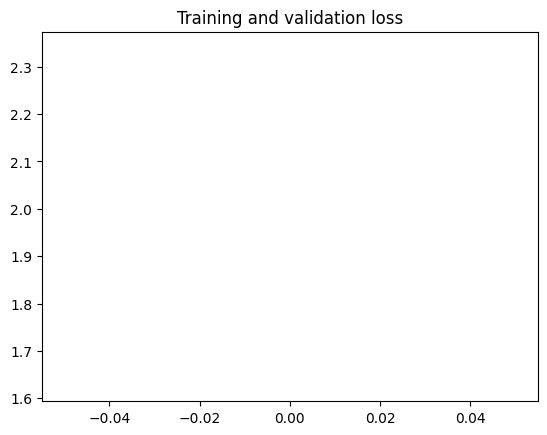

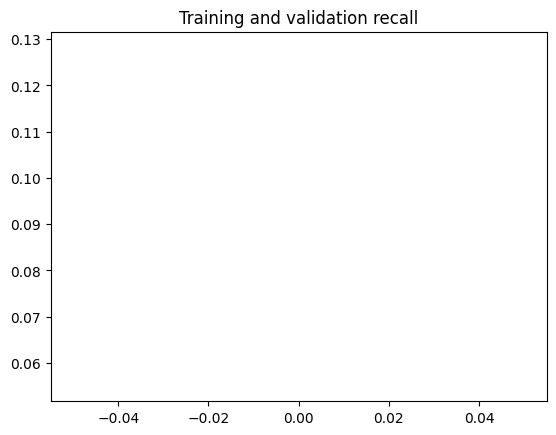

In [13]:
epochs = number_of_epochs
plt.figure()
plt.title('Training and validation loss')
plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")

plt.figure()
plt.title('Training and validation recall')
plt.plot(np.arange(0, epochs), history.history["recall"], label="train_rec")
plt.plot(np.arange(0, epochs), history.history["val_recall"], label="val_rec")

In [14]:
Y_pred = model.predict(X_test)
Y_pred_class = np.argmax(Y_pred, 1)
Y_pred_binary = []
for prediction in Y_pred_class:
    array_prediction = np.zeros(10)
    array_prediction[prediction] = 1
    Y_pred_binary.append(array_prediction)

print(sklearn.metrics.classification_report(Y_test, np.asarray(Y_pred_binary), target_names=list_possible_materials))

5/5 [==============================] - 9s 954ms/step
              precision    recall  f1-score   support

   polyester       0.00      0.00      0.00         2
polyurethane       0.00      0.00      0.00         4
      raffia       0.00      0.00      0.00         2
     leather       0.41      0.36      0.39        33
lamb-leather       0.50      0.17      0.25        12
goat-leather       0.00      0.00      0.00         1
 cow-leather       0.00      0.00      0.00         9
      fabric       0.58      0.54      0.56        35
      canvas       0.00      0.00      0.00         2
calf-leather       0.43      0.78      0.55        41

   micro avg       0.46      0.46      0.46       141
   macro avg       0.19      0.19      0.17       141
weighted avg       0.41      0.46      0.41       141
 samples avg       0.46      0.46      0.46       141



/Users/andreacivitarese/PycharmProjects/CVandDL/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
classification_report = sklearn.metrics.classification_report(Y_test, np.asarray(Y_pred_binary), target_names=list_possible_materials)
print(type(classification_report))


text_file = open("/Users/andreacivitarese/PycharmProjects/CVandDL/mobilenet_v3/test_prova.txt", "w")
n = text_file.write(classification_report)
text_file.close()

<class 'str'>


/Users/andreacivitarese/PycharmProjects/CVandDL/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
supports_for_dataset = {}
print(len(labels))

for vector in labels:
    label = ''
    for index, number in enumerate(vector):
        if number == 1:
            if label == '':
                label = label + list_possible_materials[index]
            else:
                label = label + '+' + list_possible_materials[index]
    try:
        supports_for_dataset[label] = supports_for_dataset[label] + 1
    except:
        supports_for_dataset[label] = 1

print(supports_for_dataset)


1402
{'calf-leather': 409, 'fabric': 352, 'leather': 329, 'polyurethane': 34, 'canvas': 18, 'polyester': 24, 'cow-leather': 87, 'lamb-leather': 116, 'raffia': 20, 'goat-leather': 13}


In [23]:
total = 0
for key in supports_for_dataset.keys():
    total += supports_for_dataset[key]
print(total)

1402
